In [1]:
from cell_2170_model import cell_2170
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model Voltage vs SOC curve

In [2]:
# initialize cell model with terminal voltage of 3.3 V
cell_model = cell_2170(initial_voltage=3.3)

output_variables = [
    "Terminal voltage [V]",
    "Current [A]",
    # "Electrolyte concentration [mol.m-3]",
    # "Negative particle surface concentration [mol.m-3]",
    # "Positive particle surface concentration [mol.m-3]",
    "Discharge capacity [A.h]"
]

cell_model.sim_cali.plot(output_variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=30.61180592714857, step=0.3061180592714857),…

In [3]:
cell_model.total_capacity

4.657948217566255

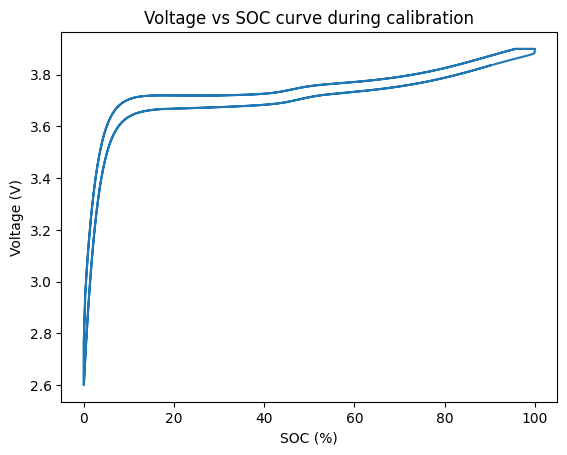

In [4]:
SOC_array = cell_model.cali_capacity_array / cell_model.total_capacity * 100

fig, ax = plt.subplots()
ax.plot(SOC_array, cell_model.cali_v_array)
ax.set_title("Voltage vs SOC curve during calibration")
ax.set_xlabel("SOC (%)")
ax.set_ylabel("Voltage (V)")
plt.show()

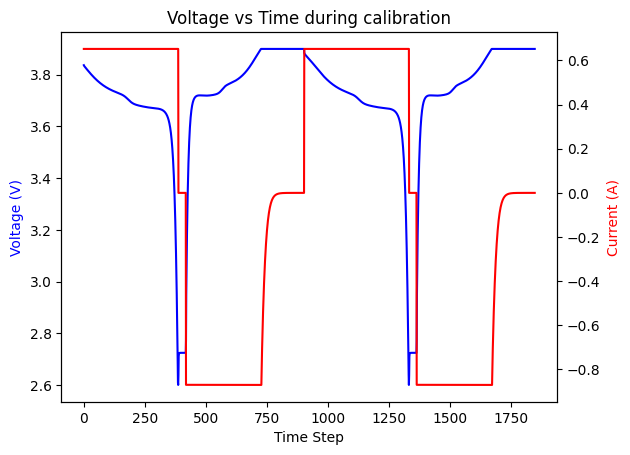

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(cell_model.cali_v_array, "b-")
ax2.plot(cell_model.cali_i_array, "r-")
ax1.set_title("Voltage vs Time during calibration")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Voltage (V)", color="b")
ax2.set_ylabel("Current (A)", color="r")
plt.show()

#### Change Y axis to Power

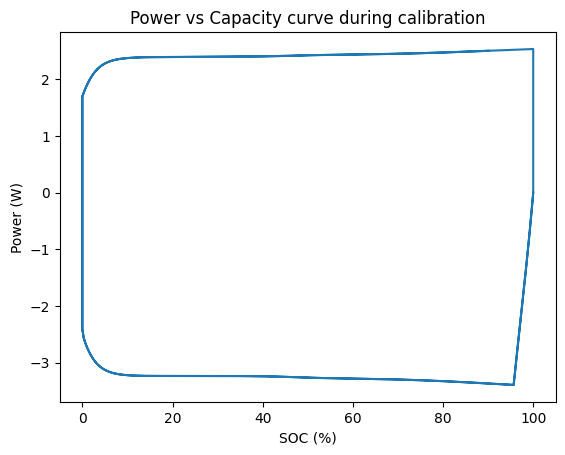

In [6]:
power_array = cell_model.cali_i_array * cell_model.cali_v_array

fig, ax = plt.subplots()
ax.plot(SOC_array, power_array)
ax.set_title("Power vs Capacity curve during calibration")
ax.set_xlabel("SOC (%)")
ax.set_ylabel("Power (W)")
plt.show()

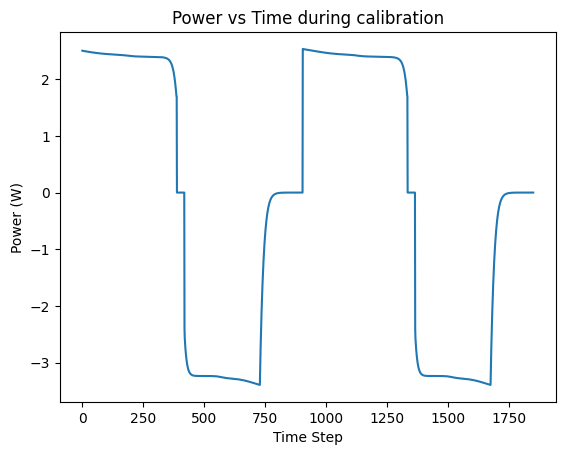

In [7]:
fig, ax = plt.subplots()
ax.plot(power_array)
ax.set_title("Power vs Time during calibration")
ax.set_xlabel("Time Step")
ax.set_ylabel("Power (W)")
plt.show()

In [8]:
cell_model.cali_capacity_array

array([4.19684164, 4.18597207, 4.1751025 , ..., 4.65794822, 4.65794822,
       4.65794822])

In [9]:
cell_capacity_array = cell_model.cali_capacity_array.reshape((len(cell_model.cali_capacity_array),1))
cell_v_array = cell_model.cali_v_array.reshape((len(cell_model.cali_v_array),1))
cell_i_array = cell_model.cali_i_array.reshape((len(cell_model.cali_i_array),1))

SOC_array = cell_capacity_array / cell_model.total_capacity
SOC_array = SOC_array.reshape((len(SOC_array),1))

pandas_array = np.concatenate((cell_v_array, cell_i_array, cell_capacity_array, SOC_array), axis=1)

In [10]:
column_values = ['voltage', 'current','capacity', 'SOC']

df_cell = pd.DataFrame(data = pandas_array, 
                       columns = column_values)

In [11]:
df_cell

,voltage,current,capacity,SOC
0,3.837032,0.652174,4.196842,0.901007
1,3.834709,0.652174,4.185972,0.898673
2,3.833377,0.652174,4.175103,0.896339
3,3.832156,0.652174,4.164233,0.894006
4,3.830971,0.652174,4.153363,0.891672
...,...,...,...,...
1845,3.900000,0.000000,4.657948,1.000000
1846,3.900000,0.000000,4.657948,1.000000
1847,3.900000,0.000000,4.657948,1.000000
1848,3.900000,0.000000,4.657948,1.000000


### Assembly of cells for model 3 battery pack
4,416 pcs of 2170 cells:
- 46 cells in parallel (summing capacity) for each group
- 96 groups in series (summing voltage).

In [12]:
df_pack = df_cell

df_pack['voltage'] = df_cell.copy()['voltage'] * 96
df_pack['current'] = df_cell.copy()['current'] * 46
df_pack['capacity'] = df_cell.copy()['capacity'] * 46
df_pack['power'] = df_pack['voltage'] * df_pack['current']

df_pack

,voltage,current,capacity,SOC,power
0,368.355070,29.999999,193.054715,0.901007,11050.651875
1,368.132106,29.999999,192.554715,0.898673,11043.962946
2,368.004172,29.999999,192.054715,0.896339,11040.124934
3,367.887003,29.999999,191.554715,0.894006,11036.609872
4,367.773183,29.999999,191.054715,0.891672,11033.195277
...,...,...,...,...,...
1845,374.399973,0.000000,214.265618,1.000000,0.000000
1846,374.399973,0.000000,214.265618,1.000000,0.000000
1847,374.399973,0.000000,214.265618,1.000000,0.000000
1848,374.399973,0.000000,214.265618,1.000000,0.000000


### Export 2 dataframes out of the df_pack
- df_charging: a whole charging session
- df_dis_charging: a whole dis-charging session

#### drop the dataset's section before the 1st charging session

In [13]:
df_pack.loc[df_pack.index[df_pack['power'] < 0][0]]

voltage     2.659909e+02
current    -3.999999e+01
capacity    5.556444e-12
SOC         2.593250e-14
power      -1.063963e+04
Name: 419, dtype: float64

In [14]:
df_pack_update = df_pack.drop(np.arange(df_pack.index[0], df_pack.index[df_pack['power'] < 0][0]))
df_pack_update

,voltage,current,capacity,SOC,power
419,265.990933,-39.99999,5.556444e-12,2.593250e-14,-10639.634669
420,283.111185,-39.99999,6.666667e-01,3.111403e-03,-11324.444587
421,291.801799,-39.99999,1.333333e+00,6.222806e-03,-11672.069023
422,299.039955,-39.99999,2.000000e+00,9.334209e-03,-11961.595219
423,305.428453,-39.99999,2.666667e+00,1.244561e-02,-12217.135066
...,...,...,...,...,...
1845,374.399973,0.00000,2.142656e+02,1.000000e+00,0.000000
1846,374.399973,0.00000,2.142656e+02,1.000000e+00,0.000000
1847,374.399973,0.00000,2.142656e+02,1.000000e+00,0.000000
1848,374.399973,0.00000,2.142656e+02,1.000000e+00,0.000000


#### export the charging section exclusively for the 1st charging session

In [15]:
df_pack_update.loc[df_pack_update.index[df_pack_update['power'] == 0][0]]

voltage     374.399978
current       0.000000
capacity    214.260455
SOC           0.999976
power         0.000000
Name: 873, dtype: float64

In [16]:
df_charging = df_pack_update.loc[np.arange(df_pack.index[df_pack['power'] < 0][0], df_pack_update.index[df_pack_update['power'] == 0][0])]
df_charging

,voltage,current,capacity,SOC,power
419,265.990933,-39.999990,5.556444e-12,2.593250e-14,-10639.634669
420,283.111185,-39.999990,6.666667e-01,3.111403e-03,-11324.444587
421,291.801799,-39.999990,1.333333e+00,6.222806e-03,-11672.069023
422,299.039955,-39.999990,2.000000e+00,9.334209e-03,-11961.595219
423,305.428453,-39.999990,2.666667e+00,1.244561e-02,-12217.135066
...,...,...,...,...,...
868,374.400000,-0.000597,2.142604e+02,9.999758e-01,-0.223645
869,374.400000,-0.000559,2.142604e+02,9.999758e-01,-0.209181
870,374.400000,-0.000521,2.142604e+02,9.999758e-01,-0.195185
871,374.400000,-0.000484,2.142605e+02,9.999759e-01,-0.181189


#### drop the dataset's section before the 2nd dis-charging session

In [17]:
df_pack_update.index[0]

419

In [18]:
df_pack_update = df_pack_update.drop(np.arange(df_pack_update.index[0], df_pack_update.index[df_pack_update['power'] > 0][0]))
df_pack_update

,voltage,current,capacity,SOC,power
904,372.981435,29.999999,214.260455,0.999976,11189.442838
905,372.665968,29.999999,213.760455,0.997642,11179.978813
906,372.509319,29.999999,213.260455,0.995309,11175.279342
907,372.377056,29.999999,212.760455,0.992975,11171.311450
908,372.256097,29.999999,212.260455,0.990642,11167.682676
...,...,...,...,...,...
1845,374.399973,0.000000,214.265618,1.000000,0.000000
1846,374.399973,0.000000,214.265618,1.000000,0.000000
1847,374.399973,0.000000,214.265618,1.000000,0.000000
1848,374.399973,0.000000,214.265618,1.000000,0.000000


#### export the charging section exclusively for the 2nd charging session

In [19]:
df_dis_charging = df_pack_update.loc[np.arange(df_pack_update.index[df_pack_update['power'] > 0][0], df_pack_update.index[df_pack_update['power'] == 0][0])]
df_dis_charging

,voltage,current,capacity,SOC,power
904,372.981435,29.999999,214.260455,0.999976,11189.442838
905,372.665968,29.999999,213.760455,0.997642,11179.978813
906,372.509319,29.999999,213.260455,0.995309,11175.279342
907,372.377056,29.999999,212.760455,0.992975,11171.311450
908,372.256097,29.999999,212.260455,0.990642,11167.682676
...,...,...,...,...,...
1329,273.978310,29.999999,1.760455,0.008216,8219.349129
1330,267.549590,29.999999,1.260455,0.005883,8026.487548
1331,260.711705,29.999999,0.760455,0.003549,7821.351001
1332,253.461588,29.999999,0.260455,0.001216,7603.847487


### Charging

### From df_charging, construct a model with concave equation

In [20]:
# take out the power drop after the peak of power
df_charging['pos_power'] = - df_charging['power']

max_power_index = df_charging.index[df_charging['pos_power'] == max(df_charging['pos_power'])]

df_charging_partial = df_charging.loc[np.arange(df_charging.index[0], max_power_index.item()+1)]
df_charging_partial

,voltage,current,capacity,SOC,power,pos_power
419,265.990933,-39.999990,5.556444e-12,2.593250e-14,-10639.634669,10639.634669
420,283.111185,-39.999990,6.666667e-01,3.111403e-03,-11324.444587,11324.444587
421,291.801799,-39.999990,1.333333e+00,6.222806e-03,-11672.069023,11672.069023
422,299.039955,-39.999990,2.000000e+00,9.334209e-03,-11961.595219,11961.595219
423,305.428453,-39.999990,2.666667e+00,1.244561e-02,-12217.135066,12217.135066
...,...,...,...,...,...,...
724,374.061164,-39.999990,2.033333e+02,9.489779e-01,-14962.442800,14962.442800
725,374.199686,-39.999990,2.040000e+02,9.520893e-01,-14967.983708,14967.983708
726,374.337976,-39.999990,2.046667e+02,9.552007e-01,-14973.515283,14973.515283
727,374.399040,-39.999990,2.049611e+02,9.565748e-01,-14975.957856,14975.957856


In [21]:
from scipy.optimize import curve_fit

x = df_charging_partial['SOC'].to_numpy()
y = df_charging_partial['pos_power'].to_numpy()

def log_func(x, a, b):
    return a*np.log(x) + b

popt, pcov = curve_fit(log_func, x, y)

popt[0], popt[1]

(193.60841209694448, 14586.99165666052)

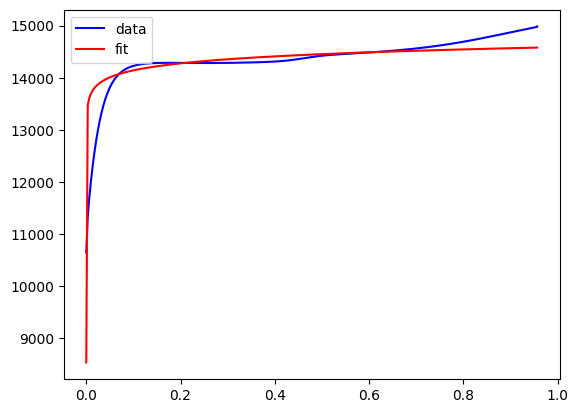

In [22]:
plt.plot(x, y, 'b-', label='data')
plt.plot(x, log_func(x, *popt), 'r-', label='fit')
plt.legend()
plt.show()

### Dis-charging

### From df_dis_charging, construct a model with concave equation

In [23]:
from scipy.optimize import curve_fit

x = df_dis_charging['SOC'].to_numpy()
y = df_dis_charging['power'].to_numpy()

def log_func(x, a, b):
    return a*np.log(x) + b

popt, pcov = curve_fit(log_func, x, y)

popt[0], popt[1]

(391.8398196859648, 11046.113923200146)

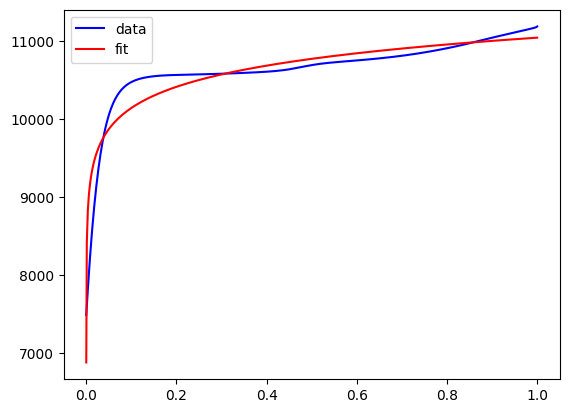

In [24]:
plt.plot(x, y, 'b-', label='data')
plt.plot(x, log_func(x, *popt), 'r-', label='fit')
plt.legend()
plt.show()

### Battery pack dis-charging power limit
$$ P(SOC) = 14.671 log(SOC) + 425.226 $$

### Battery pack charging power limit
$$ P(SOC) = 3.028 log(SOC) + 211.410 $$

### Total Capacity (unit: Ah)

4,416 pcs of 2170 cells:
- 46 cells in parallel (summing capacity) for each group
- 96 groups in series (summing voltage).

In [25]:
cell_model.total_capacity * 46

214.26561800804774

In [26]:
# max voltage during the whole experiment
# including charging and discharging

max(df_pack['voltage'])

374.4000040389297

In [27]:
# max power during charging

min(df_pack['power'])

-14983.96258973249

In [28]:
# max power during dis-charging

max(df_pack['power'])

11189.442838005123